In [1]:
import os
import shutil
import pickle
import random
import sys
import numpy as np
import pandas as pd
import duckdb
from typing import List

import requests
from io import StringIO

import ibis
import ibis.selectors as s
from ibis import _
ibis.options.interactive = True

from darts import TimeSeries, concatenate
from darts.dataprocessing.transformers import (
    Scaler,
    MissingValuesFiller,
    Mapper,
    InvertibleMapper,
)
from darts.dataprocessing import Pipeline
from darts.metrics import mape, smape, mae, ope, rmse
from darts.utils.statistics import check_seasonality, plot_acf
from darts.datasets import AirPassengersDataset, IceCreamHeaterDataset
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.likelihood_models import QuantileRegression, GumbelLikelihood, GaussianLikelihood

from darts import TimeSeries
from darts.utils.timeseries_generation import (
    gaussian_timeseries,
    linear_timeseries,
    sine_timeseries,
)
from darts.models import (
    TFTModel,
    TiDEModel,
    DLinearModel,
    NLinearModel,
    TSMixerModel
)


from torchmetrics import (
    SymmetricMeanAbsolutePercentageError, 
    MeanAbsoluteError, 
    MeanSquaredError,
)

from pytorch_lightning.callbacks.early_stopping import EarlyStopping

import warnings
warnings.filterwarnings("ignore")

# logging
import logging

# define log
logging.basicConfig(level=logging.INFO)
log = logging.getLogger(__name__)

In [2]:
import optuna
from optuna.integration import PyTorchLightningPruningCallback
from optuna.visualization import (
    plot_optimization_history,
    plot_contour,
    plot_param_importances,
    plot_pareto_front,
)

In [3]:
## will be loaded from root when deployed
from darts_wrapper import DartsGlobalModel

In [4]:
os.chdir('../..')

In [5]:
# custom modules
import src.data_engineering as de
from src import plotting
from src import utils

## Data prep

In [6]:
# connect to database
con = ibis.duckdb.connect("data/spp.ddb")
con.list_tables()

['lmp', 'mtlf', 'mtrf']

In [7]:
lmp = con.table('lmp')
lmp

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┓
┃ Interval_HE         ┃ GMTIntervalEnd_HE   ┃ timestamp_mst_HE    ┃ Settlement_Location_Name ┃ PNODE_Name ┃ LMP      ┃ MLC      ┃ MCC       ┃ MEC      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━┩
│ timestamp(6)        │ !timestamp(6)       │ timestamp(6)        │ !string                  │ !string    │ float64  │ float64  │ float64   │ float64  │
├─────────────────────┼─────────────────────┼─────────────────────┼──────────────────────────┼────────────┼──────────┼──────────┼───────────┼──────────┤
│ 2023-05-02 01:00:00 │ 2023-05-02 06:00:00 │ 2023-05-01 23:00:00 │ AESO                     │ AESO       │ 0.957908 │ 0.018525 │ -0.114242 │ 1.053625 │
│ 2023-05-02 01:00:00 │ 2023-05-02 06:00:00 │ 2023-05-01 23:00:00 │ AVA                      │ AVA        │ 0.958883 │ 0.019467 │ -0.114242 │ 1.053658 │
│ 2023-05-02 01:00:00 │ 2023-05-02 06:00:00 │ 2023-05-01 23:00:00 │ AVRN                     │ AVRN       │ 0.961042 │ 0.021650 │ -0.114242 │ 1.053633 │
│ 2023-05-02 01:00:00 │ 2023-05-02 06:00:00 │ 2023-05-01 23:00:00 │ AZPS                     │ APS        │ 0.975308 │ 0.035892 │ -0.114242 │ 1.053658 │
│ 2023-05-02 01:00:00 │ 2023-05-02 06:00:00 │ 2023-05-01 23:00:00 │ BANC                     │ BANC       │ 0.966342 │ 0.026958 │ -0.114242 │ 1.053625 │
│ 2023-05-02 01:00:00 │ 2023-05-02 06:00:00 │ 2023-05-01 23:00:00 │ BCHA                     │ BCHA       │ 0.959783 │ 0.020392 │ -0.114242 │ 1.053633 │
│ 2023-05-02 01:00:00 │ 2023-05-02 06:00:00 │ 2023-05-01 23:00:00 │ BPA                      │ BPA        │ 0.960842 │ 0.021442 │ -0.114242 │ 1.053642 │
│ 2023-05-02 01:00:00 │ 2023-05-02 06:00:00 │ 2023-05-01 23:00:00 │ CEN                      │ CEN        │ 0.973400 │ 0.034000 │ -0.114242 │ 1.053642 │
│ 2023-05-02 01:00:00 │ 2023-05-02 06:00:00 │ 2023-05-01 23:00:00 │ CHPD                     │ CHPD       │ 0.960283 │ 0.020883 │ -0.114242 │ 1.053642 │
│ 2023-05-02 01:00:00 │ 2023-05-02 06:00:00 │ 2023-05-01 23:00:00 │ CISO                     │ CISO       │ 0.968575 │ 0.029175 │ -0.114242 │ 1.053642 │
│ …                   │ …                   │ …                   │ …                        │ …          │        … │        … │         … │        … │
└─────────────────────┴─────────────────────┴─────────────────────┴──────────────────────────┴────────────┴──────────┴──────────┴───────────┴──────────┘

In [8]:
lmp = lmp.filter(_.Settlement_Location_Name.contains('PSCO'))

In [9]:
lmp.to_pandas()[['GMTIntervalEnd_HE', 'Settlement_Location_Name']].duplicated().sum()

0

In [10]:
drop_cols = [
    'Interval_HE', 'GMTIntervalEnd_HE', 'timestamp_mst_HE',
    'Settlement_Location_Name', 'PNODE_Name', 
    'MLC', 'MCC', 'MEC'
]

lmp = (
    lmp
    .mutate(unique_id = _.Settlement_Location_Name )
    .mutate(timestamp_mst = _.timestamp_mst_HE)
    # .mutate(y = _.LMP) 
    .drop(drop_cols) 
    .order_by(['unique_id', 'timestamp_mst'])
)

lmp

┏━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃ LMP       ┃ unique_id           ┃ timestamp_mst       ┃
┡━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ float64   │ !string             │ timestamp(6)        │
├───────────┼─────────────────────┼─────────────────────┤
│  0.900342 │ PSCO.BHCE.AIRPORTDL │ 2023-05-01 23:00:00 │
│  0.904992 │ PSCO.BHCE.AIRPORTDL │ 2023-05-02 00:00:00 │
│  2.601358 │ PSCO.BHCE.AIRPORTDL │ 2023-05-02 01:00:00 │
│ 13.136867 │ PSCO.BHCE.AIRPORTDL │ 2023-05-02 02:00:00 │
│ 10.744717 │ PSCO.BHCE.AIRPORTDL │ 2023-05-02 03:00:00 │
│ 13.265067 │ PSCO.BHCE.AIRPORTDL │ 2023-05-02 04:00:00 │
│ 13.555108 │ PSCO.BHCE.AIRPORTDL │ 2023-05-02 05:00:00 │
│ 15.721517 │ PSCO.BHCE.AIRPORTDL │ 2023-05-02 06:00:00 │
│ 17.135467 │ PSCO.BHCE.AIRPORTDL │ 2023-05-02 07:00:00 │
│ 13.175133 │ PSCO.BHCE.AIRPORTDL │ 2023-05-02 08:00:00 │
│         … │ …                   │ …                   │
└───────────┴─────────────────────┴─────────────────────┘

In [11]:
mtrf = con.table('mtrf')
mtrf

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Interval            ┃ GMTIntervalEnd      ┃ timestamp_mst       ┃ Wind_Forecast_MW ┃ Solar_Forecast_MW ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ timestamp(6)        │ !timestamp(6)       │ timestamp(6)        │ float64          │ float64           │
├─────────────────────┼─────────────────────┼─────────────────────┼──────────────────┼───────────────────┤
│ 2023-05-01 01:00:00 │ 2023-05-01 06:00:00 │ 2023-04-30 23:00:00 │          2085.52 │              0.00 │
│ 2023-05-01 02:00:00 │ 2023-05-01 07:00:00 │ 2023-05-01 00:00:00 │          2549.47 │              0.00 │
│ 2023-05-01 03:00:00 │ 2023-05-01 08:00:00 │ 2023-05-01 01:00:00 │          3017.06 │              0.00 │
│ 2023-05-01 04:00:00 │ 2023-05-01 09:00:00 │ 2023-05-01 02:00:00 │          3213.45 │              0.00 │
│ 2023-05-01 05:00:00 │ 2023-05-01 10:00:00 │ 2023-05-01 03:00:00 │          2723.32 │              0.00 │
│ 2023-05-01 06:00:00 │ 2023-05-01 11:00:00 │ 2023-05-01 04:00:00 │          2574.19 │              0.00 │
│ 2023-05-01 07:00:00 │ 2023-05-01 12:00:00 │ 2023-05-01 05:00:00 │          2499.79 │              0.62 │
│ 2023-05-01 08:00:00 │ 2023-05-01 13:00:00 │ 2023-05-01 06:00:00 │          2070.59 │             55.57 │
│ 2023-05-01 09:00:00 │ 2023-05-01 14:00:00 │ 2023-05-01 07:00:00 │          1672.67 │            259.53 │
│ 2023-05-01 10:00:00 │ 2023-05-01 15:00:00 │ 2023-05-01 08:00:00 │           956.07 │           1015.92 │
│ …                   │ …                   │ …                   │                … │                 … │
└─────────────────────┴─────────────────────┴─────────────────────┴──────────────────┴───────────────────┘

In [12]:
drop_cols = ['Interval', 'GMTIntervalEnd']

mtrf = (
    mtrf
    # .mutate(ds = _.timestamp_mst)
    .drop(drop_cols) 
    .order_by(['timestamp_mst'])
)

mtrf

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ timestamp_mst       ┃ Wind_Forecast_MW ┃ Solar_Forecast_MW ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ timestamp(6)        │ float64          │ float64           │
├─────────────────────┼──────────────────┼───────────────────┤
│ 2023-04-30 23:00:00 │          2085.52 │              0.00 │
│ 2023-05-01 00:00:00 │          2549.47 │              0.00 │
│ 2023-05-01 01:00:00 │          3017.06 │              0.00 │
│ 2023-05-01 02:00:00 │          3213.45 │              0.00 │
│ 2023-05-01 03:00:00 │          2723.32 │              0.00 │
│ 2023-05-01 04:00:00 │          2574.19 │              0.00 │
│ 2023-05-01 05:00:00 │          2499.79 │              0.62 │
│ 2023-05-01 06:00:00 │          2070.59 │             55.57 │
│ 2023-05-01 07:00:00 │          1672.67 │            259.53 │
│ 2023-05-01 08:00:00 │           956.07 │           1015.92 │
│ …                   │                … │                 … │
└─────────────────────┴──────────────────┴───────────────────┘

In [13]:
mtlf = con.table('mtlf')
mtlf

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Interval            ┃ GMTIntervalEnd      ┃ timestamp_mst       ┃ MTLF  ┃ Averaged_Actual ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ timestamp(6)        │ !timestamp(6)       │ timestamp(6)        │ int32 │ float64         │
├─────────────────────┼─────────────────────┼─────────────────────┼───────┼─────────────────┤
│ 2023-05-01 00:00:00 │ 2023-05-01 05:00:00 │ 2023-04-30 22:00:00 │  7209 │          6972.0 │
│ 2023-05-01 01:00:00 │ 2023-05-01 06:00:00 │ 2023-04-30 23:00:00 │  6790 │          6620.0 │
│ 2023-05-01 02:00:00 │ 2023-05-01 07:00:00 │ 2023-05-01 00:00:00 │  6477 │          6384.0 │
│ 2023-05-01 03:00:00 │ 2023-05-01 08:00:00 │ 2023-05-01 01:00:00 │  6319 │          6226.0 │
│ 2023-05-01 04:00:00 │ 2023-05-01 09:00:00 │ 2023-05-01 02:00:00 │  6278 │          6316.0 │
│ 2023-05-01 05:00:00 │ 2023-05-01 10:00:00 │ 2023-05-01 03:00:00 │  6282 │          6440.0 │
│ 2023-05-01 06:00:00 │ 2023-05-01 11:00:00 │ 2023-05-01 04:00:00 │  6430 │          6575.0 │
│ 2023-05-01 07:00:00 │ 2023-05-01 12:00:00 │ 2023-05-01 05:00:00 │  6980 │          6879.0 │
│ 2023-05-01 08:00:00 │ 2023-05-01 13:00:00 │ 2023-05-01 06:00:00 │  7399 │          7169.0 │
│ 2023-05-01 09:00:00 │ 2023-05-01 14:00:00 │ 2023-05-01 07:00:00 │  7398 │          7252.0 │
│ …                   │ …                   │ …                   │     … │               … │
└─────────────────────┴─────────────────────┴─────────────────────┴───────┴─────────────────┘

In [14]:
drop_cols = ['Interval', 'GMTIntervalEnd',]

mtlf = (
    mtlf
    # .mutate(ds = _.timestamp_mst)
    .drop(drop_cols) 
    .order_by(['timestamp_mst'])
)

mtlf

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ timestamp_mst       ┃ MTLF  ┃ Averaged_Actual ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ timestamp(6)        │ int32 │ float64         │
├─────────────────────┼───────┼─────────────────┤
│ 2023-04-30 22:00:00 │  7209 │          6972.0 │
│ 2023-04-30 23:00:00 │  6790 │          6620.0 │
│ 2023-05-01 00:00:00 │  6477 │          6384.0 │
│ 2023-05-01 01:00:00 │  6319 │          6226.0 │
│ 2023-05-01 02:00:00 │  6278 │          6316.0 │
│ 2023-05-01 03:00:00 │  6282 │          6440.0 │
│ 2023-05-01 04:00:00 │  6430 │          6575.0 │
│ 2023-05-01 05:00:00 │  6980 │          6879.0 │
│ 2023-05-01 06:00:00 │  7399 │          7169.0 │
│ 2023-05-01 07:00:00 │  7398 │          7252.0 │
│ …                   │     … │               … │
└─────────────────────┴───────┴─────────────────┘

In [15]:
all_df = (
    mtlf
    .left_join(mtrf, 'timestamp_mst')
    .select(~s.contains("_right")) # remove 'dt_right'
    .left_join(lmp, 'timestamp_mst')
    .select(~s.contains("_right")) # remove 'dt_right'
    .order_by(['unique_id', 'timestamp_mst'])
)
all_df 


┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃ timestamp_mst       ┃ MTLF  ┃ Averaged_Actual ┃ Wind_Forecast_MW ┃ Solar_Forecast_MW ┃ LMP       ┃ unique_id           ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ timestamp(6)        │ int32 │ float64         │ float64          │ float64           │ float64   │ string              │
├─────────────────────┼───────┼─────────────────┼──────────────────┼───────────────────┼───────────┼─────────────────────┤
│ 2023-05-01 23:00:00 │  6818 │          6809.0 │          3571.73 │              0.00 │  0.900342 │ PSCO.BHCE.AIRPORTDL │
│ 2023-05-02 00:00:00 │  6597 │          6511.0 │          3339.18 │              0.00 │  0.904992 │ PSCO.BHCE.AIRPORTDL │
│ 2023-05-02 01:00:00 │  6507 │          6372.0 │          3195.45 │              0.00 │  2.601358 │ PSCO.BHCE.AIRPORTDL │
│ 2023-05-02 02:00:00 │  6344 │          6334.0 │          3296.07 │              0.00 │ 13.136867 │ PSCO.BHCE.AIRPORTDL │
│ 2023-05-02 03:00:00 │  6384 │          6362.0 │          2997.68 │              0.00 │ 10.744717 │ PSCO.BHCE.AIRPORTDL │
│ 2023-05-02 04:00:00 │  6550 │          6466.0 │          3080.94 │              0.00 │ 13.265067 │ PSCO.BHCE.AIRPORTDL │
│ 2023-05-02 05:00:00 │  6903 │          6723.0 │          2774.13 │              0.54 │ 13.555108 │ PSCO.BHCE.AIRPORTDL │
│ 2023-05-02 06:00:00 │  7252 │          7095.0 │          2799.46 │             49.52 │ 15.721517 │ PSCO.BHCE.AIRPORTDL │
│ 2023-05-02 07:00:00 │  7370 │          7236.0 │          2290.13 │            204.61 │ 17.135467 │ PSCO.BHCE.AIRPORTDL │
│ 2023-05-02 08:00:00 │  7270 │          7199.0 │          2254.61 │            592.32 │ 13.175133 │ PSCO.BHCE.AIRPORTDL │
│ …                   │     … │               … │                … │                 … │         … │ …                   │
└─────────────────────┴───────┴─────────────────┴──────────────────┴───────────────────┴───────────┴─────────────────────┘

In [16]:
all_df.count()

┌─────────┐
│ 1353408 │
└─────────┘

In [17]:
all_df = (
    all_df
    .drop_null(['unique_id'])
    # .mutate(hour = _.ds.hour())
    # .mutate(weekday = _.ds.day_of_week.index())
    # .mutate(month = _.ds.month())
    .mutate(re_ratio = (_.Wind_Forecast_MW + _.Solar_Forecast_MW) / _.MTLF)
)

all_df

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━┓
┃ timestamp_mst       ┃ MTLF  ┃ Averaged_Actual ┃ Wind_Forecast_MW ┃ Solar_Forecast_MW ┃ LMP       ┃ unique_id           ┃ re_ratio ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━┩
│ timestamp(6)        │ int32 │ float64         │ float64          │ float64           │ float64   │ string              │ float64  │
├─────────────────────┼───────┼─────────────────┼──────────────────┼───────────────────┼───────────┼─────────────────────┼──────────┤
│ 2023-05-01 23:00:00 │  6818 │          6809.0 │          3571.73 │              0.00 │  0.900342 │ PSCO.BHCE.AIRPORTDL │ 0.523868 │
│ 2023-05-02 00:00:00 │  6597 │          6511.0 │          3339.18 │              0.00 │  0.904992 │ PSCO.BHCE.AIRPORTDL │ 0.506166 │
│ 2023-05-02 01:00:00 │  6507 │          6372.0 │          3195.45 │              0.00 │  2.601358 │ PSCO.BHCE.AIRPORTDL │ 0.491079 │
│ 2023-05-02 02:00:00 │  6344 │          6334.0 │          3296.07 │              0.00 │ 13.136867 │ PSCO.BHCE.AIRPORTDL │ 0.519557 │
│ 2023-05-02 03:00:00 │  6384 │          6362.0 │          2997.68 │              0.00 │ 10.744717 │ PSCO.BHCE.AIRPORTDL │ 0.469561 │
│ 2023-05-02 04:00:00 │  6550 │          6466.0 │          3080.94 │              0.00 │ 13.265067 │ PSCO.BHCE.AIRPORTDL │ 0.470373 │
│ 2023-05-02 05:00:00 │  6903 │          6723.0 │          2774.13 │              0.54 │ 13.555108 │ PSCO.BHCE.AIRPORTDL │ 0.401951 │
│ 2023-05-02 06:00:00 │  7252 │          7095.0 │          2799.46 │             49.52 │ 15.721517 │ PSCO.BHCE.AIRPORTDL │ 0.392854 │
│ 2023-05-02 07:00:00 │  7370 │          7236.0 │          2290.13 │            204.61 │ 17.135467 │ PSCO.BHCE.AIRPORTDL │ 0.338499 │
│ 2023-05-02 08:00:00 │  7270 │          7199.0 │          2254.61 │            592.32 │ 13.175133 │ PSCO.BHCE.AIRPORTDL │ 0.391600 │
│ …                   │     … │               … │                … │                 … │         … │ …                   │        … │
└─────────────────────┴───────┴─────────────────┴──────────────────┴───────────────────┴───────────┴─────────────────────┴──────────┘

In [18]:
all_df_pd = all_df.to_pandas()
all_df_pd

,timestamp_mst,MTLF,Averaged_Actual,Wind_Forecast_MW,Solar_Forecast_MW,LMP,unique_id,re_ratio
0,2023-05-01 23:00:00,6818,6809.0,3571.73,0.00,0.900342,PSCO.BHCE.AIRPORTDL,0.523868
1,2023-05-02 00:00:00,6597,6511.0,3339.18,0.00,0.904992,PSCO.BHCE.AIRPORTDL,0.506166
2,2023-05-02 01:00:00,6507,6372.0,3195.45,0.00,2.601358,PSCO.BHCE.AIRPORTDL,0.491079
3,2023-05-02 02:00:00,6344,6334.0,3296.07,0.00,13.136867,PSCO.BHCE.AIRPORTDL,0.519557
4,2023-05-02 03:00:00,6384,6362.0,2997.68,0.00,10.744717,PSCO.BHCE.AIRPORTDL,0.469561
...,...,...,...,...,...,...,...,...
1353378,2024-08-23 19:00:00,10450,10672.0,2119.33,45.43,26.209600,PSCO_UPIP_UPI,0.207154
1353379,2024-08-23 20:00:00,10227,10320.0,1323.80,0.00,19.366533,PSCO_UPIP_UPI,0.129442
1353380,2024-08-23 21:00:00,9848,9768.0,1528.30,0.00,17.024517,PSCO_UPIP_UPI,0.155189
1353381,2024-08-23 22:00:00,9121,9064.0,1888.73,0.00,13.986367,PSCO_UPIP_UPI,0.207075


In [19]:
all_df_pd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1353383 entries, 0 to 1353382
Data columns (total 8 columns):
 #   Column             Non-Null Count    Dtype         
---  ------             --------------    -----         
 0   timestamp_mst      1353383 non-null  datetime64[us]
 1   MTLF               1353383 non-null  int32         
 2   Averaged_Actual    1353383 non-null  float64       
 3   Wind_Forecast_MW   1353383 non-null  float64       
 4   Solar_Forecast_MW  1353383 non-null  float64       
 5   LMP                1353383 non-null  float64       
 6   unique_id          1353383 non-null  object        
 7   re_ratio           1353383 non-null  float64       
dtypes: datetime64[us](1), float64(5), int32(1), object(1)
memory usage: 77.4+ MB


In [20]:
len(all_df_pd.timestamp_mst.unique()) * len(all_df_pd.unique_id.unique())

1451268

In [21]:
node_groups = all_df_pd.unique_id.unique()
log.info(f'number of nodes: {len(node_groups)}')
node_groups

INFO:__main__:number of nodes: 126


array(['PSCO.BHCE.AIRPORTDL', 'PSCO.BHCE.BRWF1', 'PSCO.BHCE.BRWF2',
       'PSCO.BHCE.PAGS1', 'PSCO.BHCE.PAGS2', 'PSCO.BHCE.PAGS4',
       'PSCO.BHCE.PAGS5', 'PSCO.BHCE.PAGS6', 'PSCO.BHCE.PEAKVIEW',
       'PSCO.BHCE.PPLANTDL', 'PSCO.BHCE.RFDIESEL', 'PSCO.CORE.HUNTER.SLR',
       'PSCO.CORE.PIONEER.SLR', 'PSCO.CORE.VICTORY.SLR',
       'PSCO.CSUM.PRPA_SCWIND', 'PSCO.CSUM.PUEBLOHYDRO',
       'PSCO.GUZ.BRONCO', 'PSCO.HCE.BLANCAPK.SLR', 'PSCO.HCE.EAGLEVLY',
       'PSCO.HCE.HUNTER.SLR', 'PSCO.HCE.ORCHARD', 'PSCO.HCGE.BRONCO',
       'PSCO.PRPM_W.CRAIG1', 'PSCO.PRPM_W.CRAIG2', 'PSCO.PRPM_W.FLATS',
       'PSCO.PRPM_W.MEDICINEBOW', 'PSCO.PRPM_W.PRAIRIE',
       'PSCO.PRPM_W.RAWHIDE1', 'PSCO.PRPM_W.RAWHIDEA',
       'PSCO.PRPM_W.RAWHIDEB', 'PSCO.PRPM_W.RAWHIDEC',
       'PSCO.PRPM_W.RAWHIDED', 'PSCO.PRPM_W.RAWHIDEF',
       'PSCO.PRPM_W.ROUNDHOUSE', 'PSCO.PSC.BCP2', 'PSCO.PSCM.ALAMOSA.SLR',
       'PSCO.PSCM.ARAP567.CC', 'PSCO.PSCM.ATERG1', 'PSCO.PSCM.ATERG2',
       'PSCO.PSCM.BIGHORN.SLR'

In [22]:
node_groups = [node for node in node_groups if 'PSCO_' in node]
log.info(f'number of nodes: {len(node_groups)}')
node_groups

INFO:__main__:number of nodes: 9


['PSCO_BHCE',
 'PSCO_CRSP',
 'PSCO_MEAN_W',
 'PSCO_PRPM_PR',
 'PSCO_PSCM_PSCO_PSCM',
 'PSCO_PSCM_PSCP_ARPA',
 'PSCO_PSCO_PSCO_RPSP',
 'PSCO_TSPM_TS',
 'PSCO_UPIP_UPI']

In [23]:
all_df_pd = all_df_pd[all_df_pd.unique_id.isin(node_groups)].reset_index(drop=True)
all_df_pd

,timestamp_mst,MTLF,Averaged_Actual,Wind_Forecast_MW,Solar_Forecast_MW,LMP,unique_id,re_ratio
0,2023-05-01 23:00:00,6818,6809.0,3571.73,0.00,0.922608,PSCO_BHCE,0.523868
1,2023-05-02 00:00:00,6597,6511.0,3339.18,0.00,0.926283,PSCO_BHCE,0.506166
2,2023-05-02 01:00:00,6507,6372.0,3195.45,0.00,2.659375,PSCO_BHCE,0.491079
3,2023-05-02 02:00:00,6344,6334.0,3296.07,0.00,13.408308,PSCO_BHCE,0.519557
4,2023-05-02 03:00:00,6384,6362.0,2997.68,0.00,10.971367,PSCO_BHCE,0.469561
...,...,...,...,...,...,...,...,...
85399,2024-08-23 19:00:00,10450,10672.0,2119.33,45.43,26.209600,PSCO_UPIP_UPI,0.207154
85400,2024-08-23 20:00:00,10227,10320.0,1323.80,0.00,19.366533,PSCO_UPIP_UPI,0.129442
85401,2024-08-23 21:00:00,9848,9768.0,1528.30,0.00,17.024517,PSCO_UPIP_UPI,0.155189
85402,2024-08-23 22:00:00,9121,9064.0,1888.73,0.00,13.986367,PSCO_UPIP_UPI,0.207075


In [24]:
# all_df_pd.drop(['Averaged_Actual'], axis=1, errors='ignore', inplace=True)
all_df_pd.set_index('timestamp_mst', inplace=True)
all_df_pd

,MTLF,Averaged_Actual,Wind_Forecast_MW,Solar_Forecast_MW,LMP,unique_id,re_ratio
timestamp_mst,,,,,,,
2023-05-01 23:00:00,6818,6809.0,3571.73,0.00,0.922608,PSCO_BHCE,0.523868
2023-05-02 00:00:00,6597,6511.0,3339.18,0.00,0.926283,PSCO_BHCE,0.506166
2023-05-02 01:00:00,6507,6372.0,3195.45,0.00,2.659375,PSCO_BHCE,0.491079
2023-05-02 02:00:00,6344,6334.0,3296.07,0.00,13.408308,PSCO_BHCE,0.519557
2023-05-02 03:00:00,6384,6362.0,2997.68,0.00,10.971367,PSCO_BHCE,0.469561
...,...,...,...,...,...,...,...
2024-08-23 19:00:00,10450,10672.0,2119.33,45.43,26.209600,PSCO_UPIP_UPI,0.207154
2024-08-23 20:00:00,10227,10320.0,1323.80,0.00,19.366533,PSCO_UPIP_UPI,0.129442
2024-08-23 21:00:00,9848,9768.0,1528.30,0.00,17.024517,PSCO_UPIP_UPI,0.155189


## Prep model training

In [25]:
FORECAST_HORIZON = 24*5
INPUT_CHUNK_LENGTH = 2*FORECAST_HORIZON

In [26]:
futr_cols = ['MTLF', 'Wind_Forecast_MW', 'Solar_Forecast_MW', 're_ratio']
past_cols = ['Averaged_Actual']
y = ['LMP']
ids = ['unique_id']

In [27]:
all_df_pd = all_df_pd[ids + y + past_cols + futr_cols]
all_df_pd 

,unique_id,LMP,Averaged_Actual,MTLF,Wind_Forecast_MW,Solar_Forecast_MW,re_ratio
timestamp_mst,,,,,,,
2023-05-01 23:00:00,PSCO_BHCE,0.922608,6809.0,6818,3571.73,0.00,0.523868
2023-05-02 00:00:00,PSCO_BHCE,0.926283,6511.0,6597,3339.18,0.00,0.506166
2023-05-02 01:00:00,PSCO_BHCE,2.659375,6372.0,6507,3195.45,0.00,0.491079
2023-05-02 02:00:00,PSCO_BHCE,13.408308,6334.0,6344,3296.07,0.00,0.519557
2023-05-02 03:00:00,PSCO_BHCE,10.971367,6362.0,6384,2997.68,0.00,0.469561
...,...,...,...,...,...,...,...
2024-08-23 19:00:00,PSCO_UPIP_UPI,26.209600,10672.0,10450,2119.33,45.43,0.207154
2024-08-23 20:00:00,PSCO_UPIP_UPI,19.366533,10320.0,10227,1323.80,0.00,0.129442
2024-08-23 21:00:00,PSCO_UPIP_UPI,17.024517,9768.0,9848,1528.30,0.00,0.155189


In [28]:
train_start = all_df_pd.index.min() + pd.Timedelta(f'{2*INPUT_CHUNK_LENGTH}h')
test_end = all_df_pd.index.max() - pd.Timedelta(f'{2*FORECAST_HORIZON}h')
tr_tst_split =  test_end - pd.Timedelta(f'{2*INPUT_CHUNK_LENGTH}h')
log.info(f'train_start: {train_start}')
log.info(f'tr_tst_split: {tr_tst_split}')
log.info(f'test_end: {test_end}')

INFO:__main__:train_start: 2023-05-21 23:00:00
INFO:__main__:tr_tst_split: 2024-07-24 23:00:00
INFO:__main__:test_end: 2024-08-13 23:00:00


In [29]:
train_idx = (all_df_pd.index < tr_tst_split) & (all_df_pd.index > train_start)
test_idx = (all_df_pd.index > tr_tst_split) & (all_df_pd.index < test_end)
train_all = all_df_pd[train_idx]
train_all

,unique_id,LMP,Averaged_Actual,MTLF,Wind_Forecast_MW,Solar_Forecast_MW,re_ratio
timestamp_mst,,,,,,,
2023-05-22 00:00:00,PSCO_BHCE,14.889050,6436.0,6416,659.10,0.00,0.102728
2023-05-22 01:00:00,PSCO_BHCE,17.156233,6343.0,6385,648.15,0.00,0.101511
2023-05-22 02:00:00,PSCO_BHCE,15.617967,6248.0,6274,451.78,0.00,0.072008
2023-05-22 03:00:00,PSCO_BHCE,15.936433,6205.0,6251,420.91,0.00,0.067335
2023-05-22 04:00:00,PSCO_BHCE,15.825708,6198.0,6221,420.39,0.00,0.067576
...,...,...,...,...,...,...,...
2024-07-24 18:00:00,PSCO_UPIP_UPI,17.368833,12407.0,12495,1602.59,879.13,0.198617
2024-07-24 19:00:00,PSCO_UPIP_UPI,18.804967,12062.0,12100,2347.99,217.31,0.212008
2024-07-24 20:00:00,PSCO_UPIP_UPI,15.260058,11624.0,11419,3032.55,3.36,0.265865


In [30]:
test_all = all_df_pd[test_idx]
test_all

,unique_id,LMP,Averaged_Actual,MTLF,Wind_Forecast_MW,Solar_Forecast_MW,re_ratio
timestamp_mst,,,,,,,
2024-07-25 00:00:00,PSCO_BHCE,12.662442,8752.0,8284,3929.99,0.00,0.474407
2024-07-25 01:00:00,PSCO_BHCE,12.318225,8464.0,8297,3637.05,0.00,0.438357
2024-07-25 02:00:00,PSCO_BHCE,10.976717,8126.0,7949,3445.69,0.00,0.433475
2024-07-25 03:00:00,PSCO_BHCE,12.180092,7931.0,7733,3120.23,0.00,0.403495
2024-07-25 04:00:00,PSCO_BHCE,14.332242,7832.0,7667,2729.30,0.00,0.355980
...,...,...,...,...,...,...,...
2024-08-13 18:00:00,PSCO_UPIP_UPI,15.361892,10068.0,10267,3101.47,323.39,0.333579
2024-08-13 19:00:00,PSCO_UPIP_UPI,18.089308,9754.0,9868,2082.86,46.39,0.215773
2024-08-13 20:00:00,PSCO_UPIP_UPI,16.667875,9571.0,9596,2067.32,0.01,0.215437


In [31]:
def fill_missing(series):
    for i in range(len(series)):
        transformer = MissingValuesFiller()
        series[i] = transformer.transform(series[i])

<Axes: xlabel='timestamp_mst'>

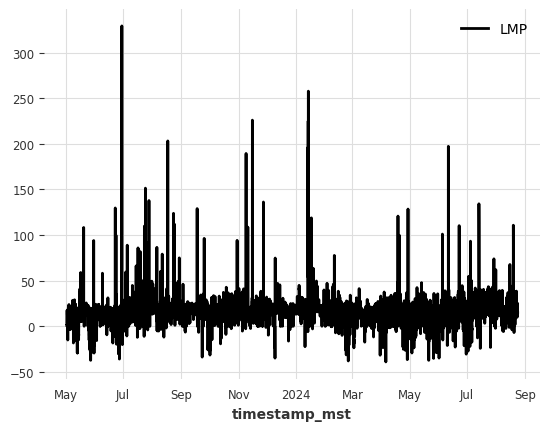

In [32]:
all_series = TimeSeries.from_group_dataframe(
    all_df_pd,
    group_cols=ids,
    value_cols=y,
    fill_missing_dates=True,
    freq='h',
)

fill_missing(all_series) 
all_series[0].plot()

<Axes: xlabel='timestamp_mst'>

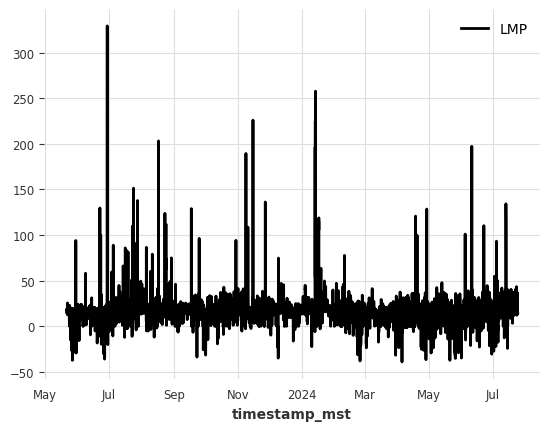

In [33]:
train_series = TimeSeries.from_group_dataframe(
    train_all,
    group_cols=ids,
    value_cols=y,
    fill_missing_dates=True,
    freq='h',
)
fill_missing(train_series)
train_series[0].plot()

<Axes: xlabel='timestamp_mst'>

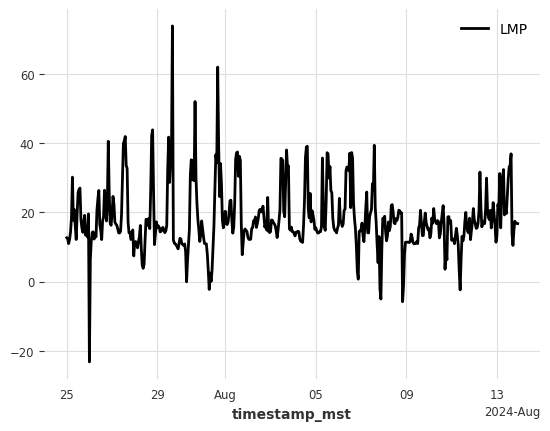

In [34]:
test_series = TimeSeries.from_group_dataframe(
    test_all,
    group_cols=ids,
    value_cols=y,
    fill_missing_dates=True,
    freq='h',
)
fill_missing(test_series)
test_series[0].plot()

<Axes: xlabel='timestamp_mst'>

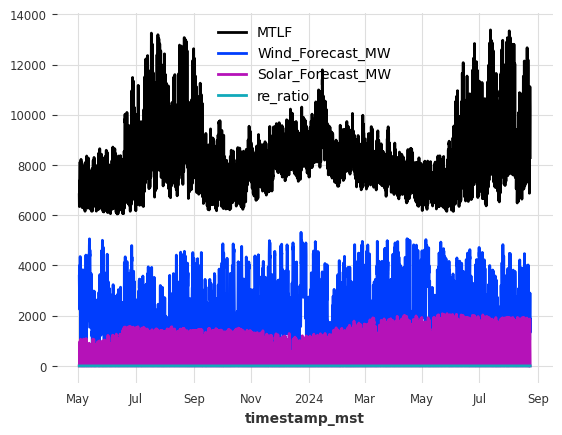

In [35]:
futr_cov = TimeSeries.from_group_dataframe(
    all_df_pd,
    group_cols=ids,
    value_cols=futr_cols,
    fill_missing_dates=True,
    freq='h',
)
fill_missing(futr_cov)
futr_cov[0].plot()

<Axes: xlabel='timestamp_mst'>

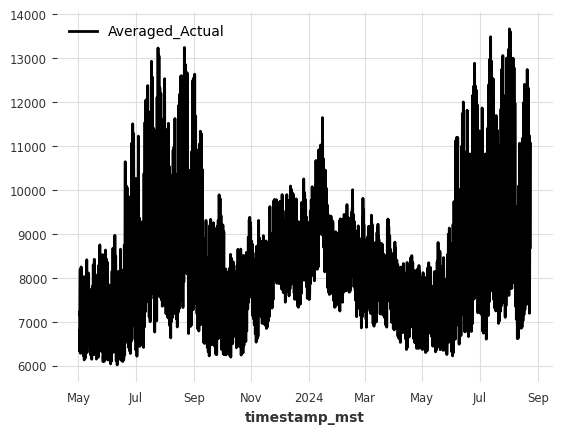

In [36]:
past_cov = TimeSeries.from_group_dataframe(
    all_df_pd,
    group_cols=ids,
    value_cols=past_cols,
    fill_missing_dates=True,
    freq='h',
)
fill_missing(past_cov)
past_cov[0].plot()

In [37]:
# test_futr_cov = TimeSeries.from_group_dataframe(
#     test_all,
#     group_cols=ids,
#     value_cols=cov_cols,
#     fill_missing_dates=True,
#     freq='h',
# )

# test_futr_cov[0].plot()

## MLFlow setup

In [38]:
import mlflow

In [39]:
# mlflow.set_tracking_uri("sqlite:///mlruns.db")
mlflow.get_tracking_uri()

'file:///home/justinfields/Documents/spp_weis_price_forecast/mlruns'

In [40]:
exp_name = 'spp_weis'

if mlflow.get_experiment_by_name(exp_name) is None:
    exp = mlflow.create_experiment(exp_name)
    
exp = mlflow.get_experiment_by_name(exp_name)
exp

<Experiment: artifact_location='file:///home/justinfields/Documents/spp_weis_price_forecast/mlruns/481193523438280627', creation_time=1725576912828, experiment_id='481193523438280627', last_update_time=1725576912828, lifecycle_stage='active', name='spp_weis', tags={}>

## Get model signature

In [41]:
node_series = train_series[0]
future_cov_series = futr_cov[0]
past_cov_series = past_cov[0]

data = {
    'series': [node_series.to_json()],
    'past_covariates': [past_cov_series.to_json()],
    'future_covariates': [future_cov_series.to_json()],
    'n': FORECAST_HORIZON,
    'num_samples': 200
}
df = pd.DataFrame(data)

ouput_example = 'the endpoint return json as a string'

In [42]:
from mlflow.models import infer_signature
darts_signature = infer_signature(df, ouput_example)
darts_signature

inputs: 
  ['series': string (required), 'past_covariates': string (required), 'future_covariates': string (required), 'n': long (required), 'num_samples': long (required)]
outputs: 
  [string (required)]
params: 
  None

## Set up hyperparameter tuning study

https://unit8co.github.io/darts/examples/17-hyperparameter-optimization.html?highlight=optuna

In [43]:
import torch
import pprint
# set up pretty printer
pp = pprint.PrettyPrinter(indent=2, sort_dicts=False)

def log_pretty(obj):
    pretty_out = f"{pp.pformat(obj)}"

    return f'{pretty_out}\n'
    
def build_fit_tsmixerx(
    series: List[TimeSeries]=train_series,
    val_series: List[TimeSeries]=test_series,
    future_covariates: List[TimeSeries]=futr_cov,
    past_covariates: List[TimeSeries]=past_cov,
    hidden_size: int=32,
    ff_size: int=128,
    num_blocks: int=2,
    forecast_horizon: int=FORECAST_HORIZON,
    input_chunk_length: int=INPUT_CHUNK_LENGTH,
    lr: float=1e-4,
    batch_size: int=64,
    n_epochs: int=4,
    force_reset: bool=True, # reset model if already exists
    callbacks=None,
):
    work_dir = os.getcwd() + '/model_checkpoints'
    MODEL_TYPE = "ts_mixer_model"
    quantiles = [0.01]+np.arange(0.05, 1, 0.05).tolist()+[0.99]
    
    #TODO: pick a metric...
    torch_metrics = MeanAbsoluteError()
    # torch_metrics = MeanSquaredError(squared=False)
    # torch_metrics = SymmetricMeanAbsolutePercentageError()
    
    encoders = {
        "datetime_attribute": {
            "future": ["hour", "dayofweek", "month"], # 
            "past": ["hour", "dayofweek", "month"], # 
        },
        "position": {
            "past": ["relative"], 
            "future": ["relative"]
        },
        "transformer": Scaler(global_fit=True)
    }

    # common parameters across models
    model_params = {
        'hidden_size': hidden_size,
        'ff_size': ff_size,
        'num_blocks': num_blocks,
        'input_chunk_length': input_chunk_length,
        'output_chunk_length': forecast_horizon,
        'batch_size': batch_size,
        'n_epochs': n_epochs,
        'add_encoders': encoders,
        'likelihood': QuantileRegression(quantiles=quantiles),  # QuantileRegression is set per default
        'optimizer_kwargs': {"lr": lr},
        'random_state': 42,
        'torch_metrics': torch_metrics,
        'use_static_covariates': False,
        'save_checkpoints': True,
        'work_dir': work_dir,
        'model_name': MODEL_TYPE, # used for checkpoint saves
        'force_reset': force_reset, # reset model if already exists
    }
    log.info(f'model_params: \n{log_pretty(model_params)}')

    # throughout training we'll monitor the validation loss for early stopping
    early_stopper = EarlyStopping("val_loss", min_delta=0.01, patience=3, verbose=True)
    if callbacks is None:
        callbacks = [early_stopper]
    else:
        callbacks = [early_stopper] + callbacks

    # detect if a GPU is available
    if torch.cuda.is_available():
        pl_trainer_kwargs = {
            "accelerator": "gpu",
            "gpus": -1,
            "auto_select_gpus": True,
            "callbacks": callbacks,
        }
    else:
        pl_trainer_kwargs = {"callbacks": callbacks}
        

    model = TSMixerModel(**model_params)

    # train the model
    fit_params = {
        'series': train_series,
        'val_series': test_series,
        'future_covariates': futr_cov,
        'past_covariates': past_cov,
        'val_future_covariates': futr_cov,
        'val_past_covariates': past_cov,
    }
    model.fit(**fit_params)

    # reload best model over course of training
    model = TSMixerModel.load_from_checkpoint(
        work_dir=work_dir,
        model_name=MODEL_TYPE
    )
    
    model.MODEL_TYPE = MODEL_TYPE

    return model
    

In [46]:
def build_fit_tft(
    series: List[TimeSeries]=train_series,
    val_series: List[TimeSeries]=test_series,
    future_covariates: List[TimeSeries]=futr_cov,
    past_covariates: List[TimeSeries]=past_cov,
    hidden_size: int=16, # Hidden state size of the TFT. It is the main hyper-parameter and common across the internal TFT architecture.
    lstm_layers: int = 1, # Number of layers for the Long Short Term Memory (LSTM) Encoder and Decoder (1 is a good default).
    num_attention_heads: int=2, # Number of attention heads (4 is a good default)
    dropout: float=0.1,
    forecast_horizon: int=FORECAST_HORIZON,
    input_chunk_length: int=INPUT_CHUNK_LENGTH,
    lr: float=1e-4,
    batch_size: int=64,
    n_epochs: int=4,
    force_reset: bool=True, # reset model if already exists
    callbacks=None,
):
    work_dir = os.getcwd() + '/model_checkpoints'
    MODEL_TYPE = "tft_model"
    quantiles = [0.01]+np.arange(0.05, 1, 0.05).tolist()+[0.99]
    
    #TODO: pick a metric...
    torch_metrics = MeanAbsoluteError()
    # torch_metrics = MeanSquaredError(squared=False)
    # torch_metrics = SymmetricMeanAbsolutePercentageError()
    
    encoders = {
        "datetime_attribute": {
            "future": ["hour", "dayofweek", "month"], # 
            "past": ["hour", "dayofweek", "month"], # 
        },
        "position": {
            "past": ["relative"], 
            "future": ["relative"]
        },
        "transformer": Scaler(global_fit=True)
    }

    # common parameters across models
    model_params = {
        'hidden_size': hidden_size,
        'lstm_layers': lstm_layers,
        'num_attention_heads': num_attention_heads,
        'dropout': dropout,
        'input_chunk_length': input_chunk_length,
        'output_chunk_length': forecast_horizon,
        'batch_size': batch_size,
        'n_epochs': n_epochs,
        'add_encoders': encoders,
        'likelihood': QuantileRegression(quantiles=quantiles),  # QuantileRegression is set per default
        'optimizer_kwargs': {"lr": lr},
        'random_state': 42,
        'torch_metrics': torch_metrics,
        'use_static_covariates': False,
        'save_checkpoints': True,
        'work_dir': work_dir,
        'model_name': MODEL_TYPE, # used for checkpoint saves
        'force_reset': force_reset, # reset model if already exists
    }
    log.info(f'model_params: \n{log_pretty(model_params)}')

    # throughout training we'll monitor the validation loss for early stopping
    early_stopper = EarlyStopping("val_loss", min_delta=0.01, patience=3, verbose=True)
    if callbacks is None:
        callbacks = [early_stopper]
    else:
        callbacks = [early_stopper] + callbacks

    # detect if a GPU is available
    if torch.cuda.is_available():
        pl_trainer_kwargs = {
            "accelerator": "gpu",
            "gpus": -1,
            "auto_select_gpus": True,
            "callbacks": callbacks,
        }
    else:
        pl_trainer_kwargs = {"callbacks": callbacks}
        

    model = TFTModel(**model_params)

    # train the model
    fit_params = {
        'series': train_series,
        'val_series': test_series,
        'future_covariates': futr_cov,
        'past_covariates': past_cov,
        'val_future_covariates': futr_cov,
        'val_past_covariates': past_cov,
    }
    model.fit(**fit_params)

    # reload best model over course of training
    model = TFTModel.load_from_checkpoint(
        work_dir=work_dir,
        model_name=MODEL_TYPE
    )
    
    model.MODEL_TYPE = MODEL_TYPE

    return model

In [ ]:
# test build fit function
# model = build_fit_tsmixerx(n_epochs=1)
model = build_fit_tft(n_epochs=1)

INFO:__main__:model_params: 
{ 'hidden_size': 16,
  'lstm_layers': 1,
  'num_attention_heads': 2,
  'dropout': 0.1,
  'input_chunk_length': 240,
  'output_chunk_length': 120,
  'batch_size': 64,
  'n_epochs': 1,
  'add_encoders': { 'datetime_attribute': { 'future': [ 'hour',
                                                        'dayofweek',
                                                        'month'],
                                            'past': [ 'hour',
                                                      'dayofweek',
                                                      'month']},
                    'position': {'past': ['relative'], 'future': ['relative']},
                    'transformer': Scaler},
  'likelihood': QuantileRegression(quantiles: Optional[List[float]] = None),
  'optimizer_kwargs': {'lr': 0.0001},
  'random_state': 42,
  'torch_metrics': MeanAbsoluteError(),
  'use_static_covariates': False,
  'save_checkpoints': True,
  'work_dir': '/home/justinfield

Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

In [ ]:
model.MODEL_TYPE

In [ ]:
model.model_params

In [ ]:
preds = model.predict(
        series=train_series, 
        n=FORECAST_HORIZON,
        past_covariates=past_cov,
        future_covariates=futr_cov,
        num_samples=200,
)

smapes = smape(test_series, preds, n_jobs=-1, verbose=True)
smape_val = np.mean(smapes)
smape_val

In [ ]:
### retest this....
# acc = model.backtest(
#     series=test_series,
#     past_covariates=past_cov,
#     future_covariates=futr_cov,
#     retrain=False,
#     forecast_horizon=FORECAST_HORIZON,
#     stride=25,
#     metric=[get_ci_error],
#     verbose=False,
#     num_samples=200,
    # retrain=False,
# )

In [ ]:
from darts.metrics.metrics import multi_ts_support, multivariate_support

# @multivariate_support
def get_ci_error(actual_series, pred_series, n_jobs=1, verbose=False):
    series_qs = pred_series.quantiles_df((0.2, 0.8))
    val_y = actual_series.pd_dataframe()
    
    eval_df = series_qs.merge(
        val_y,
        how='inner',
        left_index=True,
        right_index=True,
    )

    # 0 if u > l
    upper_error = (
        (eval_df['LMP_0.8'] - eval_df['LMP']) # upper - pred
        .apply(lambda x: min(x, 0)) # min(u-p, 0)
        .abs().mean() # sum(abs(min(u-p, 0)))
    )

    # 0 if p > l
    lower_error = (
        (eval_df['LMP_0.2'] - eval_df['LMP']) # lower - pred
        .apply(lambda x: max(x, 0)) # max(l-p, 0)
        .abs().mean() # sum(abs(max(l-p, 0)))
    )

    return upper_error + lower_error

In [ ]:
def get_ci_cover_err(actual_series, pred_series, n_jobs=1, verbose=False):
    series_qs = pred_series.quantiles_df((0.1, 0.9))
    val_y = actual_series.pd_dataframe()
    
    eval_df = series_qs.merge(
        val_y,
        how='inner',
        left_index=True,
        right_index=True,
    )

    # 0 if u > l
    cover = (
        (eval_df['LMP_0.9'] < eval_df['LMP']) |
        (eval_df['LMP_0.1'] > eval_df['LMP'])
    ).mean() # should be about 80%

    return 100 * np.abs(cover - 0.8)

In [ ]:
def objective_tsmixer(trial):
    callback = [PyTorchLightningPruningCallback(trial, monitor="val_loss")]

    # Hyperparameters
    hidden_size = trial.suggest_int("hidden_size", 16, 64)
    ff_size = trial.suggest_int("ff_size", 64, 256)
    num_blocks = trial.suggest_int("num_blocks", 1, 4)
    lr = trial.suggest_float("lr", 1e-4, 5e-4, step=1e-4)
    n_epochs = trial.suggest_int("n_epochs", 3, 10)
    

    # build and train the TCN model with these hyper-parameters:
    model = build_fit_tsmixerx(
        hidden_size=hidden_size,
        ff_size=ff_size,
        num_blocks=num_blocks,
        lr=lr,
        n_epochs=n_epochs,
        callbacks=callback,
    )

    # Evaluate how good it is on the validation set
    preds = model.predict(
        series=train_series, 
        n=len(test_series[0]),
        past_covariates=past_cov,
        future_covariates=futr_cov,
        num_samples=200,
    )

    smapes = smape(test_series, preds, n_jobs=-1, verbose=True)
    smape_val = np.mean(smapes)
    
    if smape_val!= np.nan:
        pass
    else:
        smape_val = float("inf")

    ci_error = np.mean([get_ci_cover_err(test_series[i], preds[i]) for i in range(len(preds))])
    

    return smape_val , ci_error



In [ ]:
def objective_tft(trial):
    callback = [PyTorchLightningPruningCallback(trial, monitor="val_loss")]

    # Hyperparameters
    hidden_size = trial.suggest_int("hidden_size", 8, 32)
    lstm_layers = trial.suggest_int("lstm_layers", 1, 2)
    num_attention_heads = trial.suggest_int("num_attention_heads", 1, 4)
    lr = trial.suggest_float("lr", 1e-4, 5e-4, step=1e-4)
    n_epochs = trial.suggest_int("n_epochs", 3, 6)
    

    # build and train the TCN model with these hyper-parameters:
    model = build_fit_tft(
        hidden_size=hidden_size,
        lstm_layers=lstm_layers,
        num_attention_heads=num_attention_heads,
        lr=lr,
        n_epochs=n_epochs,
        callbacks=callback,
    )

    # Evaluate how good it is on the validation set
    preds = model.predict(
        series=train_series, 
        n=len(test_series[0]),
        past_covariates=past_cov,
        future_covariates=futr_cov,
        num_samples=200,
    )

    smapes = smape(test_series, preds, n_jobs=-1, verbose=True)
    smape_val = np.mean(smapes)
    
    if smape_val!= np.nan:
        pass
    else:
        smape_val = float("inf")

    ci_error = np.mean([get_ci_cover_err(test_series[i], preds[i]) for i in range(len(preds))])
    

    return smape_val , ci_error

In [ ]:
def print_callback(study, trial):
    best_smape = min(study.best_trials, key=lambda t: t.values[0])
    best_ci = min(study.best_trials, key=lambda t: t.values[1])
    log.info(f"Current values: {trial.values}, Current params: \n{log_pretty(trial.params)}")
    log.info(f"Best SMAPE: {best_smape.values}, Best params: \n{log_pretty(best_smape.params)}")
    log.info(f"Best CI: {best_ci.values}, Best params: \n{log_pretty(best_ci.params)}")

In [ ]:
study = optuna.create_study(
    directions=["minimize", "minimize"],
    storage="sqlite:///spp_trials.db", 
    study_name="spp_weis_tft",
    load_if_exists=True,
)

study.optimize(objective_tft, n_trials=10, callbacks=[print_callback])

In [ ]:
# study = optuna.create_study(
#     directions=["minimize", "minimize"],
#     storage="sqlite:///spp_trials.db", 
#     study_name="spp_weis",
#     load_if_exists=True,
# )

# study.optimize(objective_tsmixer, n_trials=40, callbacks=[print_callback])
# # or limit time
# # study.optimize(objective, timeout=7200, callbacks=[print_callback])

In [ ]:
plot_optimization_history(study, target=lambda t: t.values[0])

In [ ]:
plot_optimization_history(study, target=lambda t: t.values[1])

In [ ]:
plot_contour(study, params=["lr", "ff_size"], target=lambda t: t.values[0])

In [ ]:
plot_param_importances(study)

In [ ]:
plot_pareto_front(study, target_names=["SMAPE", "CI Error"])

In [ ]:
# TODO: think about how to wieght values to get best model
best_model = min(study.best_trials, key=lambda t: sum(t.values))
log.info(f"Best number: {best_model.number}")
log.info(f"Best values: {best_model.values}")
log.info(f"Best params: \n{log_pretty(best_model.params)}")

## Refit and log model with best params

In [ ]:
with mlflow.start_run(experiment_id=exp.experiment_id) as run:
    # fit model with best params from study
    model = build_fit_tsmixerx(**best_model.params)
    
    log.info(f'run.info: \n{run.info}')
    artifact_path = "model_artifacts"
    metrics = {}
    params = model.model_params
    
    # back test on validation data
    acc = model.backtest(
        series=test_series,
        # series=all_series,
        past_covariates=past_cov,
        future_covariates=futr_cov,
        retrain=False,
        forecast_horizon=params['output_chunk_length'],
        stride=25,
        metric=[mae, rmse],
        verbose=False,
    )

    log.info(f'BACKTEST: acc: {acc}')
    log.info(f'BACKTEST: np.mean(acc, axis=0): {np.mean(acc, axis=0)}')
    acc_df = pd.DataFrame(
        np.mean(acc, axis=0).reshape(1,-1),
        columns=['mae', 'rmse']
    )

    # add metrics
    metrics['test_mae'] = acc_df.mae[0]
    metrics['test_rmse'] = acc_df.rmse[0]

    # final training
    final_train_series = test_series
    log.info('final training')
    model.fit(
            series=test_series,
            past_covariates=past_cov,
            future_covariates=futr_cov,
            verbose=True,
            # epochs=params['n_epochs_final'], # continue training
            )
    
    # final model back test on validation data
    acc = model.backtest(
            series=test_series,
            past_covariates=past_cov,
            future_covariates=futr_cov,
            retrain=False,
            forecast_horizon=params['output_chunk_length'],
            stride=25,
            metric=[mae, rmse],
            verbose=False,
        )

    log.info(f'TEST ACC: acc: {acc}')
    log.info(f'TEST ACC: np.mean(acc, axis=0): {np.mean(acc, axis=0)}')
    acc_df = pd.DataFrame(
        np.mean(acc, axis=0).reshape(1,-1),
        columns=['mae', 'rmse']
    )

    # add and log metrics
    metrics['mae_final'] = acc_df.mae[0]
    metrics['rmse_final'] = acc_df.rmse[0]
    mlflow.log_metrics(metrics)

    # set up path to save model
    model_path = '/'.join([artifact_path, model.MODEL_TYPE])

    shutil.rmtree(artifact_path, ignore_errors=True)
    os.makedirs(artifact_path)

    # log params
    mlflow.log_params(params)

    # save model files (model, model.ckpt) 
    # and load them to artifacts when logging the model
    model.save(model_path)

    # save MODEL_TYPE to artifacts
    # this will be used to load the model from the artifacts
    model_type_path = '/'.join([artifact_path, 'MODEL_TYPE.pkl'])
    with open(model_type_path, 'wb') as handle:
        pickle.dump(model.MODEL_TYPE, handle)
    
    # map model artififacts in dictionary
    artifacts = {
        'model': model_path,
        'model.ckpt': model_path+'.ckpt',
        'MODEL_TYPE': model_type_path,
    }
    
    # log model
    # https://www.mlflow.org/docs/latest/tutorials-and-examples/tutorial.html#pip-requirements-example
    mlflow.pyfunc.log_model(
        artifact_path='GlobalForecasting',
        code_path=['notebooks/model_training/darts_wrapper.py'],
        signature=darts_signature,
        artifacts=artifacts,
        # model will get loaded from artifacts, we don't need instantiate with one
        python_model=DartsGlobalModel(), 
        pip_requirements=["-r notebooks/model_training/requirements.txt"],
    )


## Get latest run and test predicting

In [ ]:
runs = mlflow.search_runs(
    experiment_ids = exp.experiment_id,
    # order_by=['metrics.test_mae']
    order_by=['end_time']
    )

runs.sort_values('end_time', ascending=False, inplace=True)
runs

In [ ]:
best_run_id = runs.run_id.iloc[0]
best_run_id

In [ ]:
runs['artifact_uri'].iloc[0]

In [ ]:
model_path = runs['artifact_uri'].iloc[0] + '/GlobalForecasting'

In [ ]:
loaded_model = mlflow.pyfunc.load_model(model_path)

In [ ]:
plot_series = all_series[0]
# plot_end_time = min(plot_series.end_time(), pd.Timestamp('2024-07-01T23:00:00'))
# plot_end_time = min(plot_series.end_time(), pd.Timestamp('2024-07-15T23:00:00'))
plot_end_time = min(plot_series.end_time(), pd.Timestamp('2024-07-14T23:00:00'))
plot_end_time = min(plot_series.end_time(), pd.Timestamp('2024-07-20T23:00:00'))
plot_end_time = min(plot_series.end_time(), pd.Timestamp('2024-08-01T23:00:00'))
log.info(F'plot_end_time: {plot_end_time}')

In [ ]:
plot_node_name = plot_series.static_covariates.unique_id.LMP
plot_node_name

In [ ]:
# if test_end_time < test_series.end_time():
node_series = plot_series.drop_after(plot_end_time)
    
log.info(f'plot_end_time: {plot_end_time}')
log.info(f'node_series.end_time(): {node_series.end_time()}')
future_cov_series = futr_cov[0]
past_cov_series = past_cov[0]


data = {
    'series': [node_series.to_json()],
    'past_covariates': [past_cov_series.to_json()],
    'future_covariates': [future_cov_series.to_json()],
    'n': FORECAST_HORIZON,
    'num_samples': 200
}
df = pd.DataFrame(data)

plot_cov_df = future_cov_series.pd_dataframe()
plot_cov_df = (
    plot_cov_df
    .reset_index()
    .rename(columns={'timestamp_mst':'time', 're_ratio': 'Ratio'})
)
plot_cov_df

In [ ]:
df

In [ ]:
# Predict on a Pandas DataFrame.
df['num_samples'] = 500
pred = loaded_model.predict(df)
preds = TimeSeries.from_json(pred)

In [ ]:
q_df = plotting.get_quantile_df(preds)
q_df

In [ ]:
plot_df = plotting.get_mean_df(preds).merge(
    plotting.get_quantile_df(preds),
    left_index=True,
    right_index=True,
)
plot_df 

In [ ]:
lmp_df = lmp.to_pandas().rename(
    columns={
        'LMP': 'LMP_HOURLY',
        'unique_id':'node', 
        'timestamp_mst':'time'
    })

In [ ]:
plot_df = plotting.get_plot_df(
        TimeSeries.from_json(pred),
        plot_cov_df,
        lmp_df,
        plot_node_name,
    )
plot_df.rename(columns={'mean':'mean_fcast'}, inplace=True)
plot_df

plotting.plotly_forecast(plot_df, plot_node_name)